In [2]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA



In [3]:
# white noise generator
def generate_wn(n, sigma=1):
    return np.random.normal(0, sigma, size=n)  # The first parameter makes E[e_t] = 0.

In [4]:
# autoregressive time series generator
def generate_ar(n, phis, sigma=1):
    p = len(phis)
    adj_n = n + p  # We add q values because at the beginning we have no phis available.
    e_series = generate_wn(adj_n, sigma)  # Generating a white noise.

    ar = [e_series[0]]  # We start the series with a random value
    for i in range(1, adj_n):
        visible_phis = phis[0:min(p, i)]  # At first, we only "see" some of the phis.
        visible_series = ar[i - min(p, i):i]  # The same happens to the white noise.

        reversed_phis = visible_phis[::-1]

        # Main equation.
        ar_t = e_series[i] + np.dot(reversed_phis, visible_series)

        ar.append(ar_t)

    ar = ar[p:]  # Dropping the first values that did not use all the phis.

    return ar

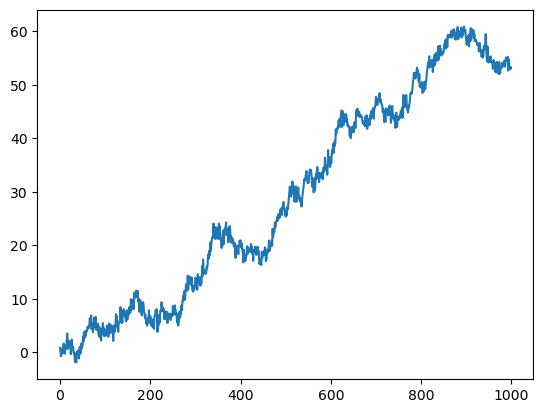

In [12]:
timeseries = generate_ar(1000, [0.5, 0.3, 0.2], 1)

# plot time series
plt.plot(timeseries)
plt.show()

In [13]:
# STL decomposition
stl = STL(timeseries, period=12)
result = stl.fit()


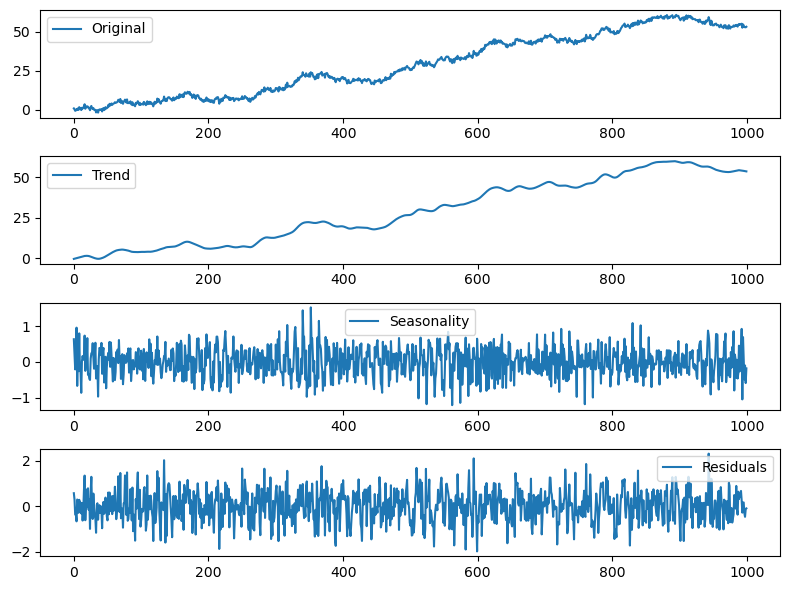

In [14]:

# Plot the original data, trend, seasonal, and residual components
plt.figure(figsize=(8, 6))

plt.subplot(411)
plt.plot(timeseries, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(result.seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(result.resid, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

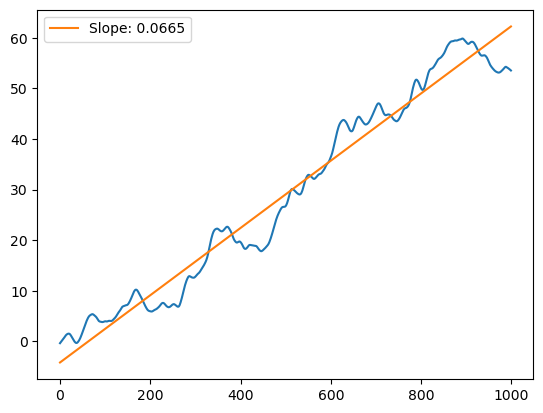

In [26]:
# fit linear model to trend component to get slope
t = np.arange(len(result.trend))
slope = np.polyfit(t, result.trend, 1)[0]
intercept = np.polyfit(t, result.trend, 1)[1]

# plot trend and linear regression line
plt.plot(t, result.trend)
plt.plot(t, slope*t + intercept, label=f'Slope: {slope:.4f}')
plt.legend()
plt.show()


c:\Users\mjgoldkuhle\anaconda3\envs\exploration\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


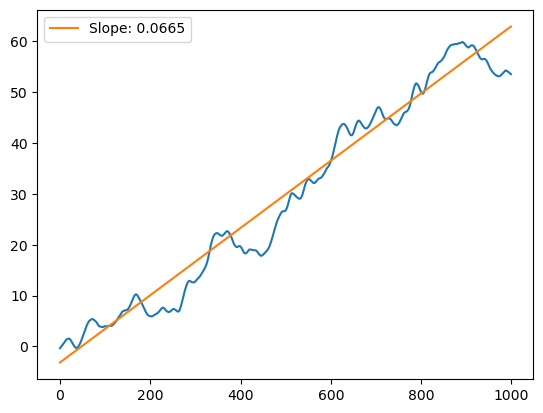

In [20]:
# also fit Theil-Sen estimator to trend component
from sklearn.linear_model import TheilSenRegressor


# Reshape the data to fit the model
t = np.arange(len(result.trend)).reshape(-1, 1)
trend = result.trend.reshape(-1, 1)

# Fit a Theil-Sen regressor to the trend component
reg = TheilSenRegressor().fit(t, trend)

# Get the slope (coef_) and intercept (intercept_)
slope_tsr = reg.coef_[0]
intercept_tsr = reg.intercept_

# Plot the trend and the regression line
plt.plot(t, trend)
plt.plot(t, slope_tsr*t + intercept_tsr, label=f'Slope: {slope:.4f}')
plt.legend()
plt.show()

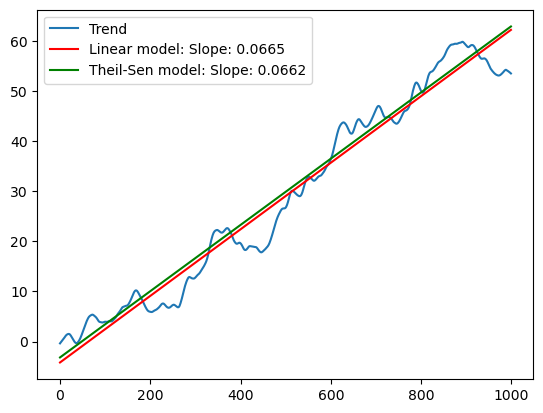

In [27]:
# Plot the trend, the ARIMA model, and the Theil-Sen regression line
plt.plot(t, trend, label='Trend')
plt.plot(t, slope*t + intercept, color='red', label=f'Linear model: Slope: {slope:.4f}')
plt.plot(t, slope_tsr*t + intercept_tsr, color='green', label=f'Theil-Sen model: Slope: {slope_tsr:.4f}') # Theil-Sen would be more robust to outliers
plt.legend()
plt.show()

In [55]:
# Fit an ARIMA model to the trend component

model = ARIMA(result.trend, order=(1,0,0)) 
model_fit = model.fit()
model_fit.summary()


c:\Users\mjgoldkuhle\anaconda3\envs\exploration\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 485.819
Date:                Tue, 16 Apr 2024   AIC                           -965.639
Time:                        16:29:32   BIC                           -950.915
Sample:                             0   HQIC                          -960.043
                               - 1000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.9980      9.371     -1.174      0.241     -29.365       7.368
ar.L1          0.9999      0.001   1401.357      0.000       0.998       1.001
sigma2         0.0220      0.001     25.119      0.000       0.020       0.024
===================================================================================
Ljung-Box (L1) (Q):                 967.58   Jarque-Bera (JB):                25.48
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                            -0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""